# Probando conexion con la base de datos

In [3]:
pip install python-dotenv

  Using cached python_dotenv-1.1.1-py3-none-any.whl.metadata (24 kB)
Note: you may need to restart the kernel to use updated packages.


In [1]:
import psycopg2
from dotenv import load_dotenv
import os

# Load environment variables from .env
load_dotenv()

# Fetch variables
USER = os.getenv("user")
PASSWORD = os.getenv("password")
HOST = os.getenv("host")
PORT = os.getenv("port")
DBNAME = os.getenv("dbname")

# Connect to the database
try:
    connection = psycopg2.connect(
        user=USER,
        password=PASSWORD,
        host=HOST,
        port=PORT,
        dbname=DBNAME
    )
    print("Connection successful!")
    
    # Create a cursor to execute SQL queries
    cursor = connection.cursor()
    
    # Example query
    cursor.execute("SELECT NOW();")
    result = cursor.fetchone()
    print("Current Time:", result)

    # Close the cursor and connection
    #cursor.close()
    #connection.close()
    #print("Connection closed.")

except Exception as e:
    print(f"Failed to connect: {e}")

Connection successful!
Current Time: (datetime.datetime(2025, 10, 28, 2, 14, 11, 60031, tzinfo=datetime.timezone.utc),)


## Listando tablas disponibles

In [2]:
cursor = connection.cursor()
cursor.execute("""
    SELECT table_name
    FROM information_schema.tables
    WHERE table_schema = 'public'
""")

tables = cursor.fetchall()
print("Tablas encontradas:")
for table in tables:
    print(table[0])

cursor.close()

Tablas encontradas:
n8n_chat_histories
airbnb_listings_final
geography_columns
geometry_columns
spatial_ref_sys
scraped_data
tweets_results
google_search
instagram_posts
trivago_hoteles
facebook_posts


## Listando campos de la tabla facebook_posts

In [3]:
table_name = 'facebook_posts'  

cursor = connection.cursor()
cursor.execute("""
    SELECT column_name, data_type
    FROM information_schema.columns
    WHERE table_name = %s
""", (table_name,))

columns = cursor.fetchall()
print(f"Columnas en {table_name}:")
for column in columns:
    print(f"- {column[0]} ({column[1]})")

cursor.close()

Columnas en facebook_posts:
- comment_count (integer)
- view_count (integer)
- music (jsonb)
- reactions_count (integer)
- comments (jsonb)
- video (jsonb)
- created_at (timestamp with time zone)
- feedback_id (text)
- author_id (text)
- transcript (text)
- share_count (text)
- like_count (text)
- post_id (text)
- image_url (text)
- author (text)
- description (text)
- url (text)
- thumbnail (text)
- video_url (text)
- captions_url (text)


In [ ]:
pip install hdfs

# Seleccionamos la data

In [20]:
import pandas as pd
import psycopg2
from dotenv import load_dotenv
import os

# Load environment variables from .env
load_dotenv()

# Fetch variables
USER = os.getenv("user")
PASSWORD = os.getenv("password")
HOST = os.getenv("host")
PORT = os.getenv("port")
DBNAME = os.getenv("dbname")

# Conexión a tu base de datos
connection = psycopg2.connect(
        user=USER,
        password=PASSWORD,
        host=HOST,
        port=PORT,
        dbname=DBNAME
    )

table_name = 'facebook_posts'
query = f"SELECT * FROM {table_name};"

df = pd.read_sql(query, connection)
df.to_csv("facebook_posts.csv", index=False,encoding='utf-8', quoting=1)
print(df.head())
connection.close()

/tmp/ipykernel_6279/836399780.py:28: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, connection)


            post_id                  author  \
0   732574745273542      Luisito el das das   
1  1604314470532320             SC Gonzalez   
2  1467005400929895  Michel Dubraska Alfano   
3  2908275766022845         Rajib Choudhury   
4   941195313282924        কাঁচা মিঠে ট্যুর   

                                         description  \
0  Hoy les voy a mostrar un lugar muy bonito y es...   
1  If I have 4 days in Delhi … what are the place...   
2  I have one extra day in New Delhi, any ideas o...   
3                       India Gate 🇮🇳\n\n📍 New Delhi   
4  In this video i describe about 15 Top-Rated To...   

                                                 url  \
0  https://www.facebook.com/luisitodasdas1/videos...   
1  https://www.facebook.com/groups/38573540239023...   
2  https://www.facebook.com/groups/38573540239023...   
3  https://www.facebook.com/groups/15285565906614...   
4  https://www.facebook.com/109097457260426/video...   

                                           

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   post_id          42 non-null     object             
 1   author           42 non-null     object             
 2   description      40 non-null     object             
 3   url              42 non-null     object             
 4   thumbnail        4 non-null      object             
 5   video_url        4 non-null      object             
 6   captions_url     0 non-null      object             
 7   feedback_id      42 non-null     object             
 8   comment_count    42 non-null     int64              
 9   view_count       4 non-null      float64            
 10  reactions_count  42 non-null     int64              
 11  comments         42 non-null     object             
 12  created_at       42 non-null     datetime64[ns, UTC]
 13  author_id        38 no

# Almacenamos los datos en HDFS

In [9]:
import subprocess

In [22]:
hdfs_path = "raw/facebook/facebook_posts.csv"

subprocess.run(["hdfs", "dfs", "-put", "-f", "facebook_posts.csv", hdfs_path], check=True)

print("Archivo cargado a HDFS:", hdfs_path)


Archivo cargado a HDFS: raw/facebook/facebook_posts.csv


# Procesamos los datos

## Api Facebook

In [14]:
import ast
from pyspark.sql import SparkSession
from pyspark.sql.functions import col,when,regexp_replace, from_json, explode
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, ArrayType,FloatType, TimestampType

In [67]:

spark = SparkSession.builder \
    .appName("FacebookPostsProcessingV2") \
    .getOrCreate()


schema = StructType([
    StructField("post_id", StringType(), True),
    StructField("author", StringType(), True),
    StructField("description", StringType(), True),
    StructField("url", StringType(), True),
    StructField("thumbnail", StringType(), True),
    StructField("video_url", StringType(), True),
    StructField("captions_url", StringType(), True),
    StructField("feedback_id", StringType(), True),
    StructField("comment_count", IntegerType(), True),
    StructField("view_count", FloatType(), True),
    StructField("reactions_count", IntegerType(), True),
    StructField("comments", StringType(), True),
    StructField("created_at", TimestampType(), True),
    StructField("author_id", StringType(), True),
    StructField("transcript", StringType(), True),
    StructField("music", StringType(), True),
    StructField("share_count", StringType(), True),
    StructField("like_count", StringType(), True),
    StructField("video", StringType(), True),
    StructField("image_url", StringType(), True)
])

raw_df = spark.read \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .option("multiLine", "true") \
    .option("quote", "\"") \
    .option("escape", "\"") \
    .option("encoding", "UTF-8") \
    .option("delimiter", ",") \
    .schema(schema) \
    .csv("hdfs://localhost:9000/user/upao/raw/facebook/facebook_posts.csv")

raw_df.printSchema()
print("Filas:", raw_df.count())
raw_df.show(5)

25/10/27 22:27:09 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


root
 |-- post_id: string (nullable = true)
 |-- author: string (nullable = true)
 |-- description: string (nullable = true)
 |-- url: string (nullable = true)
 |-- thumbnail: string (nullable = true)
 |-- video_url: string (nullable = true)
 |-- captions_url: string (nullable = true)
 |-- feedback_id: string (nullable = true)
 |-- comment_count: integer (nullable = true)
 |-- view_count: float (nullable = true)
 |-- reactions_count: integer (nullable = true)
 |-- comments: string (nullable = true)
 |-- created_at: timestamp (nullable = true)
 |-- author_id: string (nullable = true)
 |-- transcript: string (nullable = true)
 |-- music: string (nullable = true)
 |-- share_count: string (nullable = true)
 |-- like_count: string (nullable = true)
 |-- video: string (nullable = true)
 |-- image_url: string (nullable = true)

Filas: 42
+----------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------+--------------------+

### Leyendo directamende del dataframe

In [85]:
# Iniciar Spark
spark = SparkSession.builder \
    .appName("FacebookPostsProcessing") \
    .getOrCreate()

schema = StructType([
    StructField("post_id", StringType(), True),
    StructField("author", StringType(), True),
    StructField("description", StringType(), True),
    StructField("url", StringType(), True),
    StructField("thumbnail", StringType(), True),
    StructField("video_url", StringType(), True),
    StructField("captions_url", StringType(), True),
    StructField("feedback_id", StringType(), True),
    StructField("comment_count", IntegerType(), True),
    StructField("view_count", FloatType(), True),
    StructField("reactions_count", IntegerType(), True),
    StructField("comments", StringType(), True),
    StructField("created_at", TimestampType(), True),
    StructField("author_id", StringType(), True),
    StructField("transcript", StringType(), True),
    StructField("music", StringType(), True),
    StructField("share_count", StringType(), True),
    StructField("like_count", StringType(), True),
    StructField("video", StringType(), True),
    StructField("image_url", StringType(), True)
])

raw_df_lg = spark.createDataFrame(df, schema=schema)

# Ver esquema
raw_df_lg.printSchema()

# Contar filas
print("Filas:", raw_df_lg.count())

# Mostrar primeras filas
raw_df_lg.show(5)

25/10/27 22:40:39 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


root
 |-- post_id: string (nullable = true)
 |-- author: string (nullable = true)
 |-- description: string (nullable = true)
 |-- url: string (nullable = true)
 |-- thumbnail: string (nullable = true)
 |-- video_url: string (nullable = true)
 |-- captions_url: string (nullable = true)
 |-- feedback_id: string (nullable = true)
 |-- comment_count: integer (nullable = true)
 |-- view_count: float (nullable = true)
 |-- reactions_count: integer (nullable = true)
 |-- comments: string (nullable = true)
 |-- created_at: timestamp (nullable = true)
 |-- author_id: string (nullable = true)
 |-- transcript: string (nullable = true)
 |-- music: string (nullable = true)
 |-- share_count: string (nullable = true)
 |-- like_count: string (nullable = true)
 |-- video: string (nullable = true)
 |-- image_url: string (nullable = true)

Filas: 42
+----------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------+--------------------+

In [68]:
raw_df.filter(col("description").isNull()).show()

+-----------------+---------------+-----------+--------------------+---------+---------+------------+--------------------+-------------+----------+---------------+--------------------+--------------------+---------------+----------+-----+-----------+----------+-----+---------+
|          post_id|         author|description|                 url|thumbnail|video_url|captions_url|         feedback_id|comment_count|view_count|reactions_count|            comments|          created_at|      author_id|transcript|music|share_count|like_count|video|image_url|
+-----------------+---------------+-----------+--------------------+---------+---------+------------+--------------------+-------------+----------+---------------+--------------------+--------------------+---------------+----------+-----+-----------+----------+-----+---------+
|31551441477836714|Turismo Mundial|       NULL|https://www.faceb...|     NULL|     NULL|        NULL|ZmVlZGJhY2s6MzE1N...|            0|      NULL|              4|   

### Seleccionamos las columnas que nos serviran

In [73]:
## Datos de post ##
posts_columns = [
    "post_id",
    "author",
    "description",
    "created_at",
    "reactions_count",
    "comment_count"
]

posts_df = raw_df.select(*posts_columns)

# Revisar el resultado
posts_df.show(5)
posts_df.printSchema()

+----------------+--------------------+--------------------+--------------------+---------------+-------------+
|         post_id|              author|         description|          created_at|reactions_count|comment_count|
+----------------+--------------------+--------------------+--------------------+---------------+-------------+
| 732574745273542|  Luisito el das das|Hoy les voy a mos...|2025-09-28 12:07:...|            970|           64|
|1604314470532320|         SC Gonzalez|If I have 4 days ...|2025-09-28 13:02:...|             29|           49|
|1467005400929895|Michel Dubraska A...|I have one extra ...|2025-09-28 13:02:...|             20|           16|
|2908275766022845|     Rajib Choudhury|India Gate 🇮🇳\n...|2025-09-28 13:03:...|             62|            2|
| 941195313282924|    কাঁচা মিঠে ট্যুর|In this video i d...|2025-09-28 13:03:...|              5|            0|
+----------------+--------------------+--------------------+--------------------+---------------+---------

### Total de datos con descripción nula

In [70]:
posts_df.filter(col("description").isNull()).count()

2

### Eliminando datos con descripción nula

In [75]:
posts_df.filter(col("description").isNull()).show()

+-----------------+---------------+-----------+--------------------+---------------+-------------+
|          post_id|         author|description|          created_at|reactions_count|comment_count|
+-----------------+---------------+-----------+--------------------+---------------+-------------+
|31551441477836714|Turismo Mundial|       NULL|2025-09-28 22:42:...|              4|            0|
| 2514063592259784|   Alexandro CC|       NULL|2025-09-28 23:00:...|             99|            6|
+-----------------+---------------+-----------+--------------------+---------------+-------------+



In [76]:
posts_df_nonull = posts_df.filter(posts_df.description.isNotNull())
posts_df_nonull.show()

+----------------+--------------------+--------------------+--------------------+---------------+-------------+
|         post_id|              author|         description|          created_at|reactions_count|comment_count|
+----------------+--------------------+--------------------+--------------------+---------------+-------------+
| 732574745273542|  Luisito el das das|Hoy les voy a mos...|2025-09-28 12:07:...|            970|           64|
|1604314470532320|         SC Gonzalez|If I have 4 days ...|2025-09-28 13:02:...|             29|           49|
|1467005400929895|Michel Dubraska A...|I have one extra ...|2025-09-28 13:02:...|             20|           16|
|2908275766022845|     Rajib Choudhury|India Gate 🇮🇳\n...|2025-09-28 13:03:...|             62|            2|
| 941195313282924|    কাঁচা মিঠে ট্যুর|In this video i d...|2025-09-28 13:03:...|              5|            0|
|4049893928608482|        Krishanu Roy|My wife and me ar...|2025-09-28 13:03:...|             11|         

In [77]:
posts_df_nonull.count()

40

### Eliminando duplicados

In [78]:
posts_final_df = posts_df_nonull.dropDuplicates(["post_id"])

# Mostrar resultado
posts_final_df.show()

+-----------------+--------------------+--------------------+--------------------+---------------+-------------+
|          post_id|              author|         description|          created_at|reactions_count|comment_count|
+-----------------+--------------------+--------------------+--------------------+---------------+-------------+
|10041599719270496|        Julio Sócola|Entrada a la ciud...|2025-09-30 23:52:...|            370|           51|
| 1027196462108337|         Mochileando|Así puedes organi...|2025-09-28 23:02:...|           1452|          286|
| 1114396044213087|       Mincetur Perú|🌍✨ ¡Feliz Día Mu...|2025-09-28 22:43:...|            779|           21|
| 1232064725616617|          Visit Peru|Happy World Touri...|2025-09-30 23:24:...|             70|           12|
| 1329831338507505|     Conociendo Perú|✅ #ÚLTIMAHORA 😲?...|2025-09-30 23:20:...|           1028|          284|
| 1388386615680111|     Descubre Tumbes|Unos de los lugar...|2025-09-30 23:52:...|            167|

In [79]:
posts_final_df.count()

40

### Normalizando comentarios

In [57]:
from pyspark.sql.functions import col, regexp_replace, split, explode, regexp_extract,length, trim

#### Eliminar nulos

In [121]:
# Filtrar comentarios no nulos y no vacíos
raw_df_nonull = raw_df.filter(
    (col("comments").isNotNull()) & (length(trim(col("comments"))) > 2)  # >2 porque '[]' tiene longitud 2
)

In [122]:
raw_df.count()

42

In [123]:
raw_df_nonull.count()

37

#### Eliminar corchetes exteriores

In [125]:
# Limpiar corchetes exteriores
clean_df = raw_df_nonull.withColumn(
    "comments_clean",
    regexp_replace(col("comments"), r"^\[|\]$", "")
)

#### Separar comentarios

In [128]:
# Separar comentarios individuales por '},{'
exploded_df = clean_df.withColumn(
    "comment_single",
    explode(split(col("comments_clean"), r"\},\s*\{"))
)

#### Limpiar llaves sobrantes

In [134]:
exploded_df = exploded_df.withColumn(
    "comment_single",
    regexp_replace(col("comment_single"), r"^\{|\}$", "")
)

#### Limpiar la columna comment_single para manejar saltos de línea dentro de text

In [136]:
exploded_df = exploded_df.withColumn(
    "comment_clean",
    regexp_replace(col("comment_single"), r"\n", " ")  # reemplaza saltos de línea por espacio
)

#### Extraer los comentarios individuales

In [139]:
exploded_df = exploded_df.withColumn(
    "comment_single",
    explode(split(col("comment_clean"), r"\},\s*\{"))  # separa cada comentario
)

#### Extraer campos con regex

In [203]:
# Extraer campos con regex
final_df = exploded_df.select(
    col("post_id"),
    regexp_extract(col("comment_single"), r"'id':([^,]+)", 1).alias("comment_id"),
    regexp_extract(col("comment_single"),r"['\"]text['\"]:\s*['\"](.*?)['\"].*?['\"]author['\"]",1).alias("text"),
    regexp_extract(col("comment_single"), r"'reaction_count':\s*(\d+)", 1).alias("reaction_count"),
    regexp_extract(col("comment_single"), r"'author':\s*\{[^}]*?'id':\s*'([^']+)'", 1).alias("author_id"),
    regexp_extract(col("comment_single"), r"'author':\s*\{[^}]*?'name':\s*'([^']+)'", 1).alias("author_name"),
    regexp_extract(col("comment_single"), r"'author':\s*\{[^}]*?'gender':\s*'([^']+)'", 1).alias("author_gender")
)

#### Quitar espacios extras

In [222]:
comments_final_df = final_df.select(
    [trim(col(c)).alias(c) for c in final_df.columns]
)

In [223]:
comments_final_df.show()

+----------------+--------------------+--------------------+--------------+--------------------+--------------------+-------------+
|         post_id|          comment_id|                text|reaction_count|           author_id|         author_name|author_gender|
+----------------+--------------------+--------------------+--------------+--------------------+--------------------+-------------+
| 732574745273542|'Y29tbWVudDo1ODY5...|Muy Buenos días e...|             2|pfbid02CKSkkRXeSA...|       Leandro Vidal|         MALE|
| 732574745273542|'Y29tbWVudDo1ODY5...|Bonito lugar luis...|             1|pfbid02XzPAapr4Vc...|    Gonzalo Espinoza|         MALE|
|1604314470532320|'Y29tbWVudDoxNjA0...|Maybe..\n\nDay 1\...|             3|          1615213796|Amanda Nabilla Kh...|       FEMALE|
|1604314470532320|'Y29tbWVudDoxNjA0...|           Rishikesh|             3|      61558592587753|           Ram Singh|         MALE|
|1604314470532320|'Y29tbWVudDoxNjA0...|2 places I would ...|             1| 

#### Aun despues de limpiar nos quedaba un comentario sin texto

In [225]:
single_post_df =  comments_final_df.filter(col("post_id") == "2908275766022845")
# Seleccionar solo la columna comments y mostrarla
single_post_df.show()

+----------------+--------------------+--------------------+--------------+--------------------+-----------+-------------+
|         post_id|          comment_id|                text|reaction_count|           author_id|author_name|author_gender|
+----------------+--------------------+--------------------+--------------+--------------------+-----------+-------------+
|2908275766022845|'Y29tbWVudDoyOTA4...|We stayed in Delh...|             1|pfbid0QDetyjzZ168...|Tanu Tanuja|       FEMALE|
|2908275766022845|'Y29tbWVudDoyOTA4...|                    |             1|pfbid0QDetyjzZ168...|Tanu Tanuja|       FEMALE|
+----------------+--------------------+--------------------+--------------+--------------------+-----------+-------------+



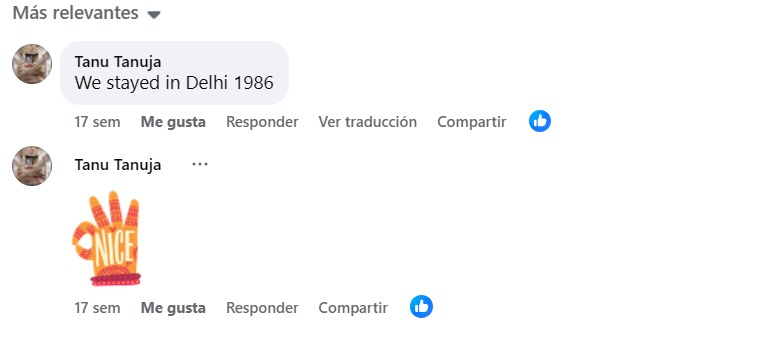

#### Eliminando comentarios que no poseen texto:

In [226]:
comments_final_df = comments_final_df.filter(trim(col("text")) != "")

In [227]:
posts_final_df.show()

+-----------------+--------------------+--------------------+--------------------+---------------+-------------+
|          post_id|              author|         description|          created_at|reactions_count|comment_count|
+-----------------+--------------------+--------------------+--------------------+---------------+-------------+
|10041599719270496|        Julio Sócola|Entrada a la ciud...|2025-09-30 23:52:...|            370|           51|
| 1027196462108337|         Mochileando|Así puedes organi...|2025-09-28 23:02:...|           1452|          286|
| 1114396044213087|       Mincetur Perú|🌍✨ ¡Feliz Día Mu...|2025-09-28 22:43:...|            779|           21|
| 1232064725616617|          Visit Peru|Happy World Touri...|2025-09-30 23:24:...|             70|           12|
| 1329831338507505|     Conociendo Perú|✅ #ÚLTIMAHORA 😲?...|2025-09-30 23:20:...|           1028|          284|
| 1388386615680111|     Descubre Tumbes|Unos de los lugar...|2025-09-30 23:52:...|            167|

In [228]:
comments_final_df.show()

+----------------+--------------------+--------------------+--------------+--------------------+--------------------+-------------+
|         post_id|          comment_id|                text|reaction_count|           author_id|         author_name|author_gender|
+----------------+--------------------+--------------------+--------------+--------------------+--------------------+-------------+
| 732574745273542|'Y29tbWVudDo1ODY5...|Muy Buenos días e...|             2|pfbid02CKSkkRXeSA...|       Leandro Vidal|         MALE|
| 732574745273542|'Y29tbWVudDo1ODY5...|Bonito lugar luis...|             1|pfbid02XzPAapr4Vc...|    Gonzalo Espinoza|         MALE|
|1604314470532320|'Y29tbWVudDoxNjA0...|Maybe..\n\nDay 1\...|             3|          1615213796|Amanda Nabilla Kh...|       FEMALE|
|1604314470532320|'Y29tbWVudDoxNjA0...|           Rishikesh|             3|      61558592587753|           Ram Singh|         MALE|
|1604314470532320|'Y29tbWVudDoxNjA0...|2 places I would ...|             1| 

# Guardando la data limpia en HDFS

## Creamos una funcion para guardar la data procesada

In [229]:
def save_to_hdfs(df, path):
    (
        df.write
        .option("header", "true")
        .option("quote", "\"")
        .option("escape", "\"")
        .option("multiLine", "true")
        .option("encoding", "UTF-8")
        .option("delimiter", ",")
        .mode("overwrite")
        .csv(path)
    )

## Guardamos los datos en formato csv

In [230]:
save_to_hdfs(comments_final_df, "hdfs://localhost:9000/user/upao/processed/facebook/facebook_coments_clean.csv")
print("Archivo guardado correctamente.")

[Stage 215:>                                                        (0 + 1) / 1]

Archivo guardado correctamente.


In [231]:
save_to_hdfs(posts_final_df, "hdfs://localhost:9000/user/upao/processed/facebook/facebook_posts_clean.csv")
print("Archivo guardado correctamente.")

Archivo guardado correctamente.


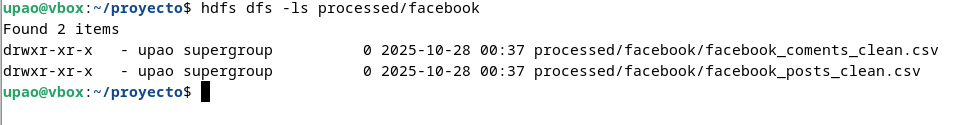

# Análisis de datos y modelado

## Leyendo datos limpios desde hadoop

In [236]:
coments_df = spark.read \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .option("multiLine", "true") \
    .option("quote", "\"") \
    .option("escape", "\"") \
    .option("encoding", "UTF-8") \
    .option("delimiter", ",") \
    .csv("hdfs://localhost:9000/user/upao/processed/facebook/facebook_coments_clean.csv")

coments_df.printSchema()
print("Filas:", coments_df.count())
coments_df.show(5)

root
 |-- post_id: long (nullable = true)
 |-- comment_id: string (nullable = true)
 |-- text: string (nullable = true)
 |-- reaction_count: integer (nullable = true)
 |-- author_id: string (nullable = true)
 |-- author_name: string (nullable = true)
 |-- author_gender: string (nullable = true)

Filas: 126
+----------------+--------------------+--------------------+--------------+--------------------+--------------------+-------------+
|         post_id|          comment_id|                text|reaction_count|           author_id|         author_name|author_gender|
+----------------+--------------------+--------------------+--------------+--------------------+--------------------+-------------+
| 732574745273542|'Y29tbWVudDo1ODY5...|Muy Buenos días e...|             2|pfbid02CKSkkRXeSA...|       Leandro Vidal|         MALE|
| 732574745273542|'Y29tbWVudDo1ODY5...|Bonito lugar luis...|             1|pfbid02XzPAapr4Vc...|    Gonzalo Espinoza|         MALE|
|1604314470532320|'Y29tbWVudDoxN

In [237]:
posts_df = spark.read \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .option("multiLine", "true") \
    .option("quote", "\"") \
    .option("escape", "\"") \
    .option("encoding", "UTF-8") \
    .option("delimiter", ",") \
    .csv("hdfs://localhost:9000/user/upao/processed/facebook/facebook_posts_clean.csv")

posts_df.printSchema()
print("Filas:", posts_df.count())
posts_df.show(5)

root
 |-- post_id: long (nullable = true)
 |-- author: string (nullable = true)
 |-- description: string (nullable = true)
 |-- created_at: timestamp (nullable = true)
 |-- reactions_count: integer (nullable = true)
 |-- comment_count: integer (nullable = true)

Filas: 40
+-----------------+---------------+--------------------+--------------------+---------------+-------------+
|          post_id|         author|         description|          created_at|reactions_count|comment_count|
+-----------------+---------------+--------------------+--------------------+---------------+-------------+
|10041599719270496|   Julio Sócola|Entrada a la ciud...|2025-09-30 23:52:...|            370|           51|
| 1027196462108337|    Mochileando|Así puedes organi...|2025-09-28 23:02:...|           1452|          286|
| 1114396044213087|  Mincetur Perú|🌍✨ ¡Feliz Día Mu...|2025-09-28 22:43:...|            779|           21|
| 1232064725616617|     Visit Peru|Happy World Touri...|2025-09-30 23:24:...|   

# Deteniendo sesion de spark

In [243]:
spark

NameError: name 'spark' is not defined

In [241]:
spark.stop()
del spark  # elimina la variable

In [242]:
try:
    spark
except NameError:
    print("SparkSession no está creada.")


SparkSession no está creada.
